<a href="https://colab.research.google.com/github/SarathSabu/Python-Notebooks/blob/main/Encoder_Decoder_Sequence_to_Sequence_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[The original tutorial](/https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/seq2seq_translation_tutorial.ipynb)
Import Python libraries and built-in functions

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In the following, let's try to understand the encoder-decoder architecture through a language translation task.

In [ ]:
### Define the indexes of the starting and ending tokens.
### The index 0 is inserted in front of every sequence.
### SOS: Start of sentence; EOS: End of sentence.
### The purpose of such special tokens: help the model understand sentence boundaries.

SOS_token = 0
EOS_token = 1

### Represent each word as a one-hot vector: a giant vector of zeroes except for a single one
### Therefore, there will be a unique index per word to use as the inputs and targets

### The following "Lang" class has two main functions:
### 1. Find the index of a word
### 2. Find the corresponding word associated with an index
### Besides, it also keep a record of the frequency for each word.
### It is designed to manage the vocabulary of a language.


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


### Turn a Unicode string to plain ASCII, thanks to
### https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

### Data clearning
### Convert all words into lowercase, remove the space
### Remove all non-letter words
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    ### search for .!? and add a space before each
    s = re.sub(r"([.!?])", r" \1", s)
    ### replace any sequence of characters that are not letters or punctuation marks
    ### with a single space.
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [ ]:
### Define a function that reads the translation file.
### The file is expected to contain parallel sentences into two language, separated by a tab character.

def readLangs(lang1, lang2, path, reverse=False):
    print("Reading lines...")
    # Read the file and split into lines
    ### lang1, lang2 = 'eng', 'fra'
    lines = open('%s/%s-%s.txt' %(path, lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

### Trim the dataset to only relatively short and simple sentences.
### The maximum length is 10 words.
### In addition, all sentences that do not follow the English prefixes listed below will be excluded from the sample
MAX_LENGTH = 10
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


### This function checks if a given sentence pair meets the filtering criteria.
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]
    return input_lang, output_lang, pairs


In [ ]:
### Read text file and split into lines.
### Further split lines into pairs
### Third, normalize the corpus to obtain a trimmed dataset
### Finally, make word lists from paired sentences
def prepareData(lang1, lang2, path, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, path, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


from google.colab import drive
drive.mount('/drive')
input_lang, output_lang, pairs = prepareData('eng', 'fra', '/drive/My Drive/info617/data', True)
### Select and print a random element from the sequence, pairs.
print(random.choice(pairs))

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['vous etes tres emotives', 'you re very emotional']


In [ ]:
pairs[:10]

[['je vais bien', 'i m ok'],
 ['ca va', 'i m ok'],
 ['je suis gras', 'i m fat'],
 ['je suis gros', 'i m fat'],
 ['je suis en forme', 'i m fit'],
 ['je suis touche !', 'i m hit !'],
 ['je suis touchee !', 'i m hit !'],
 ['je suis malade', 'i m ill'],
 ['je suis triste', 'i m sad'],
 ['je suis timide', 'i m shy']]

In [ ]:
### Define the encoder RNN
### Here, the raw input, one-hot vectors are first embedded by the Embedding layer
### And then processed by the Dropout layer and the GRU layer.
### GRU, which stands for Gated Recurrent Unit, is a variant of the vanilla RNN implemented by the PyTorch library
### At each time step, a GRU takes in an input and a hidden state from the last timestamp
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden



### The decoder is another RNN that takes the encoder output vector and outputs a sequence of words to create the translation.
### Right below is the implementation of a simple decoder without using any attention mechanism.
### At each step, the decoder is given an input token and a hidden state.
### The initial input token is the start-of-string <SOS> token.
### The initual hidden state is the last hidden state of the encoder.

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        ### The initial input token is the start-of-string <SOS> token.
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        ### The initual hidden state is the last hidden state of the encoder.
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        ### Below is the process of iterative decoding
        ### For each timestep, the decoder passes the embedding and the previous hidden state to the GRU
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                ### Teacher forcing: Feed the target as the next input
                ### "Teacher forcing" may be used during training, where the actual
                ### target word, instead of the prediction, is fed as the next input.
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden


In [ ]:
### Define the attention mechanism
### Here, the Bahdanau Attention is implemented
### For more detail, see the paper listed below:
### Chorowski, J. K., Bahdanau, D., Serdyuk, D., Cho, K., & Bengio, Y. (2015). Attention-based models for speech recognition. Advances in neural information processing systems, 28.
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        ### W, U, and V are three linear layers.
        ### They are used to calculate the attention weights.
        ### hidden_size is the dimension of the hidden state in the encoder and decoder.
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        ### Calculate the affinity scores between one decoder hidde state and all encoder hidden states
        ### The "query" corresponds to the decoder's current hidden state at time t.
        ### The "keys" are the encoder's hidden states across all time steps.
        ### Calculate the affinity score.
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        ### By a softmax operation, the affinity scores are normalized to weights
        weights = F.softmax(scores, dim=-1)
        ### The context vector is a weighted average of the "keys", the encoder's hidden states
        ### The weights are the normalized affinity scores.
        ### The function torch.bmm performs a batch matrix-matrix product of matrices weights and keys
        context = torch.bmm(weights, keys)
        return context, weights


In [ ]:
### Define the decoder that integrates the attention mechanism.
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        ### Similarly, the initial input token is the start-of-string <SOS> token.
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        ### The initual hidden state is the last hidden state of the encoder.
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            ### For each time step, calculate the decoder's output, hidden state, and the attention weights
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    ### The following method performs a single decoding step.
    def forward_step(self, input, hidden, encoder_outputs):
        ### First, encode the encoder's input through an embedding layer.
        embedded =  self.dropout(self.embedding(input))
        ### The query is the decoder's current hidden state
        query = hidden.permute(1, 0, 2)
        ### The context vector and the the attention weights are calculated as described earlier
        context, attn_weights = self.attention(query, encoder_outputs)
        ### The input of the GRU is the concatenation of the embedded input and the the context vector
        input_gru = torch.cat((embedded, context), dim=2)
        ### The GRU accepts the concatenated input and the decoder's previous hidden state as its input
        output, hidden = self.gru(input_gru, hidden)
        ### Another linear transformation on top of the GRU's output
        output = self.out(output)
        return output, hidden, attn_weights


In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Prepare the data loader for model training
def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', path, True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    ### The "train_data" includes both the input sentences and the target sentences (translations)
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    ### The "train_dataloader" contains segments of size "batch_size".
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [ ]:
### Define one single training epoch
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        ### Feed in the input_tensor, and get the encoder's hidden state.
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        ### Calculate the value of the loss function based on the decoder's output and the target tensor.
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    ### Here, the negative log likelihood loss is used to train a classification problem with n classes.
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn



In [ ]:
hidden_size = 128
batch_size = 32

path = '/drive/My Drive/Teaching/2025 Spring/INFO 617/Lecture 13 April 14/data'
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


In [ ]:
train(train_dataloader, encoder, decoder, 30, print_every=5, plot_every=5)


0m 47s (- 3m 58s) (5 16%) 1.4977
1m 28s (- 2m 56s) (10 33%) 0.6455
2m 7s (- 2m 7s) (15 50%) 0.3280
2m 49s (- 1m 24s) (20 66%) 0.1821
3m 29s (- 0m 41s) (25 83%) 0.1147
4m 9s (- 0m 0s) (30 100%) 0.0813


In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.savefig("Attention_Map.png")

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>
input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


<ipython-input-24-c651243d8684>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-c651243d8684>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
<ipython-input-24-c651243d8684>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-c651243d8684>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


input = je suis reellement fiere de vous
output = you are very proud of you are <EOS>


<ipython-input-24-c651243d8684>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-c651243d8684>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


<Figure size 640x480 with 0 Axes>

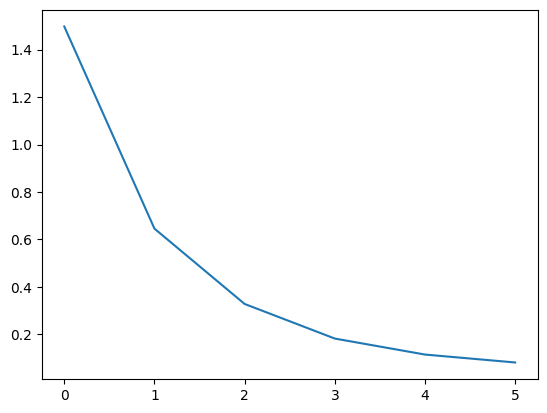

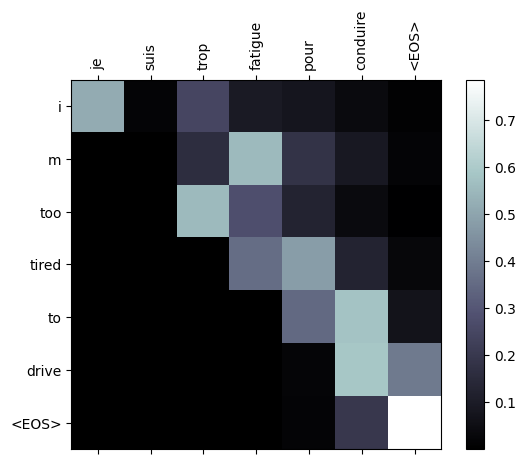

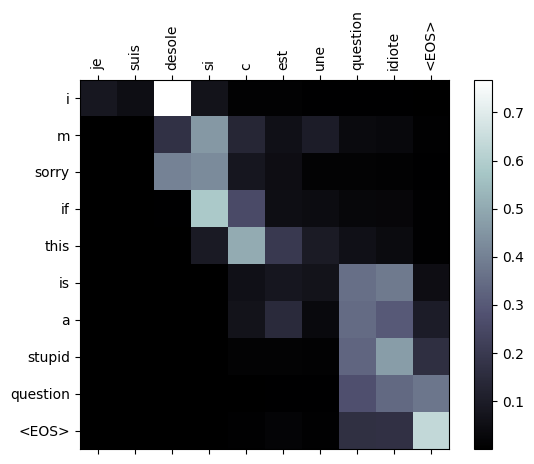

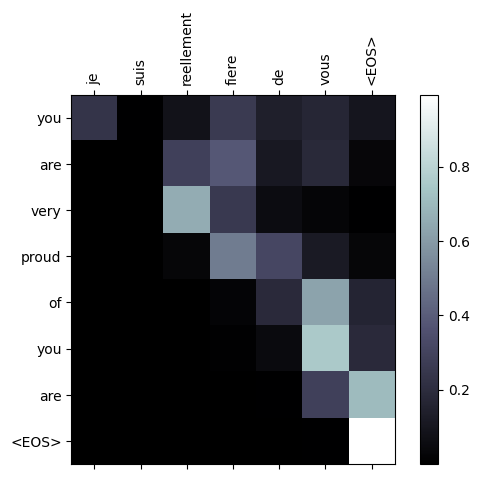

In [ ]:
evaluateAndShowAttention('je suis trop fatigue pour conduire')
evaluateAndShowAttention('je suis desole si c est une question idiote')
evaluateAndShowAttention('je suis reellement fiere de vous')